**Jagung V 4**
* With VGG16 Pre-Trained Model with 1 layer

**Metrics:**
* Test loss: 0.1835143268108368
* Test accuracy: 0.9377593398094177

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D,
from keras.optimizers import Adam, RMSprop
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.keras.backend.clear_session()

In [4]:
# import shutil
# shutil.rmtree("Jagung-data")

%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Split train test 
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/Pertanian/Jagung", output="Jagung-data", seed=42, ratio=(.8, .1,.1), group_prefix=None) 


Copying files: 4787 files [00:45, 105.05 files/s]


In [6]:
training_dir = os.path.join('Jagung-data', 'train')
testing_dir = os.path.join('Jagung-data', 'test')
validating_dir = os.path.join('Jagung-data', 'val')

In [7]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
    shuffle=True,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=128
)

num_classes = train_generator.num_classes

validation_generator = validation_datagen.flow_from_directory(
	validating_dir,
	target_size=(224,224),
    shuffle=True,
	class_mode='categorical',
  batch_size=128
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=128
)

Found 3828 images belonging to 4 classes.
Found 477 images belonging to 4 classes.
Found 482 images belonging to 4 classes.


In [8]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'Corn__common_rust': 0, 'Corn__gray_leaf_spot': 1, 'Corn__healthy': 2, 'Corn__northern_leaf_blight': 3}
['Corn__common_rust', 'Corn__gray_leaf_spot', 'Corn__healthy', 'Corn__northern_leaf_blight']


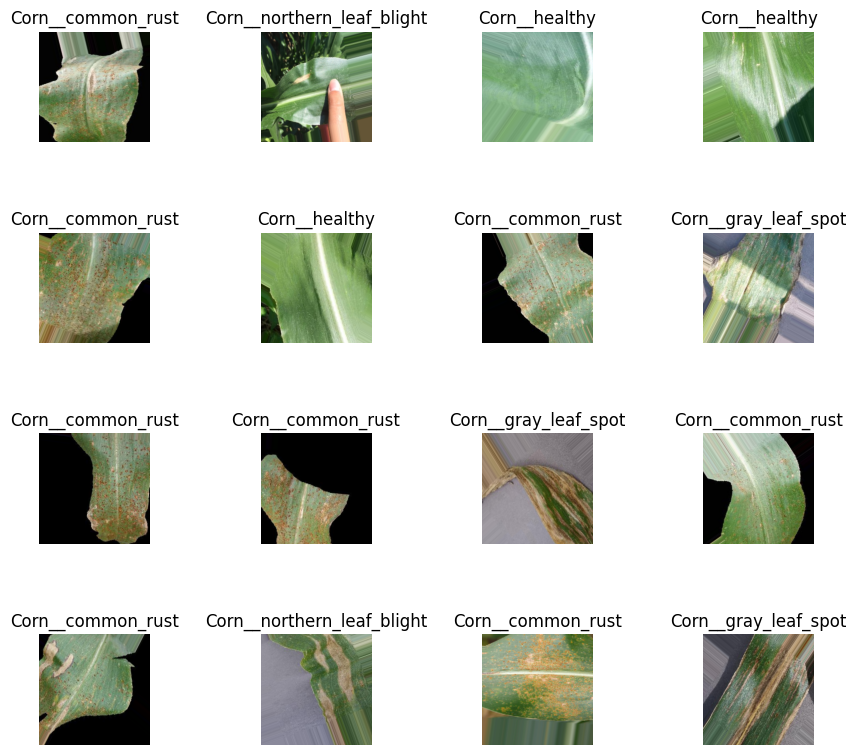

In [9]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()


In [13]:
# Define Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

In [14]:
def generator_to_dataset(generator):
    output_types = (tf.float32, tf.float32)
    output_shapes = (tf.TensorShape([None, 224, 224, 3]), tf.TensorShape([None, generator.num_classes]))

    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=output_types,
        output_shapes=output_shapes
    )

    return dataset

train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)
testing_dataset = generator_to_dataset(testing_generator)

buffer_size = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)
testing_dataset = testing_dataset.prefetch(buffer_size=buffer_size)

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate

def inception_block(previous_layer, filters):
    tower1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(previous_layer)
    tower1 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(tower1)

    tower2 = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(previous_layer)
    tower2 = Conv2D(filters[3], (5, 5), padding='same', activation='relu')(tower2)

    tower3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(previous_layer)
    tower3 = Conv2D(filters[4], (1, 1), padding='same', activation='relu')(tower3)

    tower4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(previous_layer)

    # Concatenate the output of the towers
    output = Concatenate(axis=-1)([tower1, tower2, tower3, tower4])

    return output

In [26]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Create a new model by adding your own top layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 27,562,308
Trainable params: 12,847,620
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
learning_rate = 0.001

model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_generator, 
                    epochs=100,
                    validation_data = validation_generator, 
                    verbose = 1, 
                    callbacks=[callbacks], 
                    validation_steps=3)

Epoch 1/100
30/30 [==============================] - 96s 3s/step - loss: 2.8105 - accuracy: 0.5959 - val_loss: 0.4560 - val_accuracy: 0.8359
Epoch 2/100
30/30 [==============================] - 65s 2s/step - loss: 0.4292 - accuracy: 0.8331 - val_loss: 0.3580 - val_accuracy: 0.8516
Epoch 3/100
30/30 [==============================] - 66s 2s/step - loss: 0.3742 - accuracy: 0.8540 - val_loss: 0.3383 - val_accuracy: 0.8594
Epoch 4/100
30/30 [==============================] - 65s 2s/step - loss: 0.3201 - accuracy: 0.8814 - val_loss: 0.2707 - val_accuracy: 0.8906
Epoch 5/100
30/30 [==============================] - 66s 2s/step - loss: 0.3099 - accuracy: 0.8804 - val_loss: 0.2685 - val_accuracy: 0.8828
Epoch 6/100
30/30 [==============================] - 62s 2s/step - loss: 0.2880 - accuracy: 0.8939 - val_loss: 0.2983 - val_accuracy: 0.8828
Epoch 7/100
30/30 [==============================] - 65s 2s/step - loss: 0.2813 - accuracy: 0.8934 - val_loss: 0.2466 - val_accuracy: 0.9010
Epoch 8/100
3

In [18]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

4/4 [==============================] - 9s 3s/step - loss: 0.1835 - accuracy: 0.9378
Test loss: 0.1835143268108368 / Test accuracy: 0.9377593398094177


In [19]:
predictions = model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, predicted_classes, target_names=class_labels))
print(confusion_matrix(true_classes, predicted_classes))



4/4 [==============================] - 2s 530ms/step
                            precision    recall  f1-score   support

         Corn__common_rust       0.27      0.27      0.27       132
      Corn__gray_leaf_spot       0.18      0.20      0.19       110
             Corn__healthy       0.22      0.22      0.22       117
Corn__northern_leaf_blight       0.21      0.19      0.20       123

                  accuracy                           0.22       482
                 macro avg       0.22      0.22      0.22       482
              weighted avg       0.22      0.22      0.22       482

[[36 32 26 38]
 [30 22 31 27]
 [40 28 26 23]
 [28 38 34 23]]


Potato__early_blight: 54 true positives, 6 false positives, and 51 false negatives.

Potato__healthy: 0 true positives, 8 false positives, and 8 false negatives.

Potato__late_blight: 50 true positives, 10 false positives, and 50 false negatives.


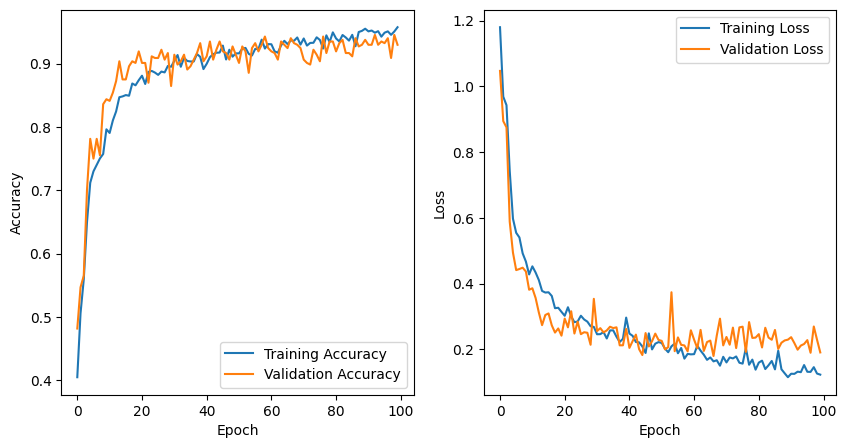

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

4/4 [==============================] - 3s 33ms/step


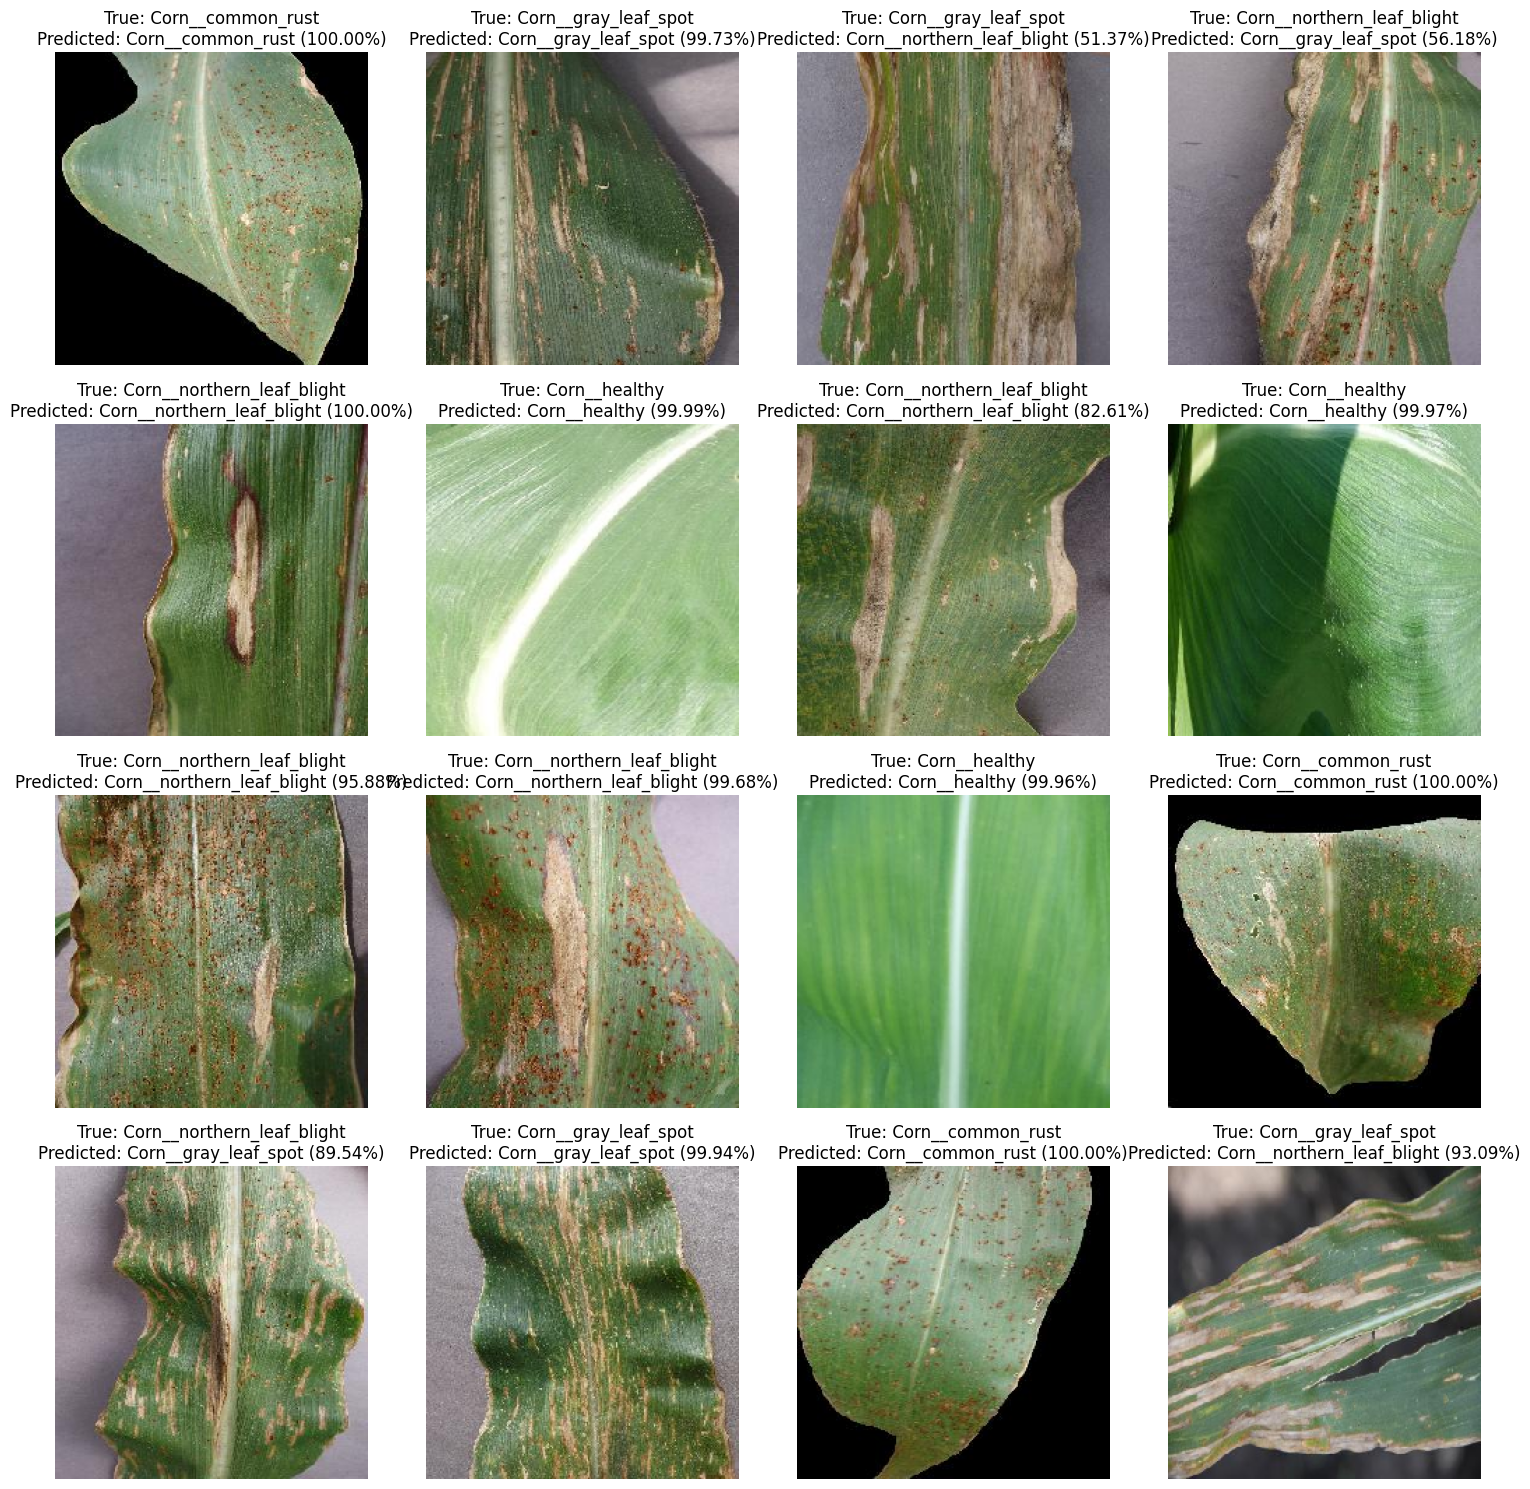

In [21]:
def plot_images(images, true_labels, predicted_labels, predicted_probs):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]} ({predicted_probs[i]:.2%})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(testing_generator))
predicted_probs = model.predict(images)
predicted_labels = [class_labels[i] for i in np.argmax(predicted_probs, axis=1)]
true_labels = [class_labels[i] for i in np.argmax(labels, axis=1)]
predicted_probs = np.max(predicted_probs, axis=1)

plot_images(images, true_labels, predicted_labels, predicted_probs)


Found 3828 images belonging to 4 classes.
1/1 [==============================] - 0s 257ms/step


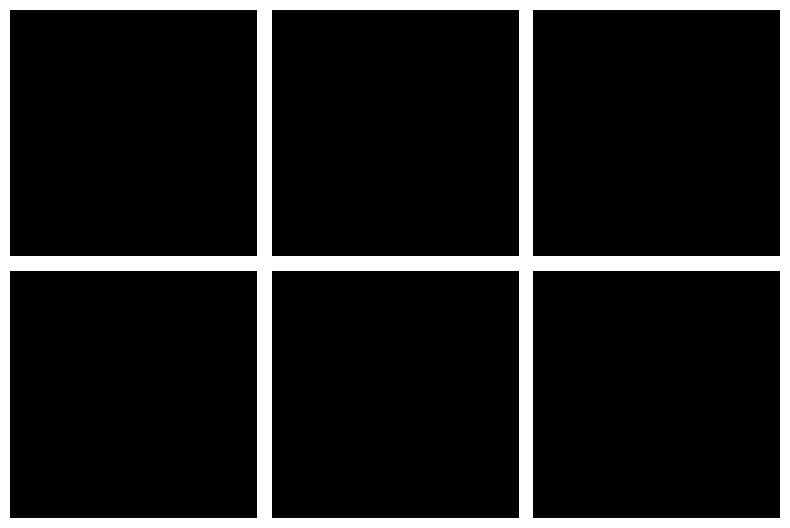

1/1 [==============================] - 0s 24ms/step


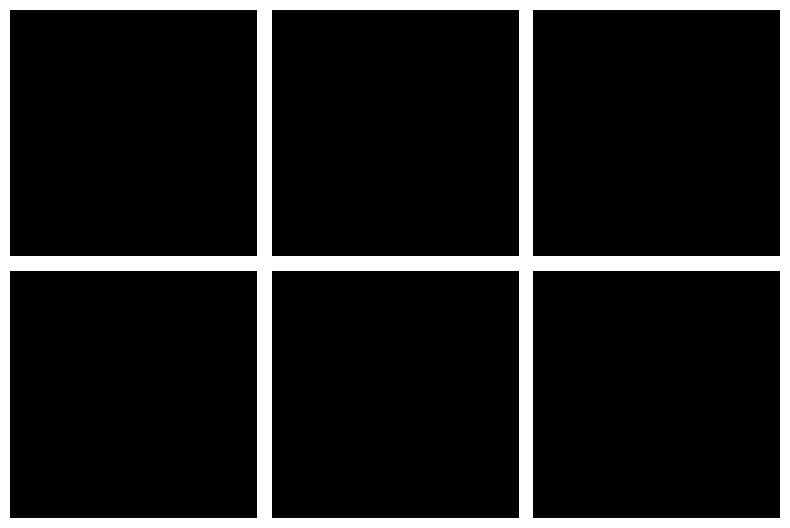

1/1 [==============================] - 0s 22ms/step


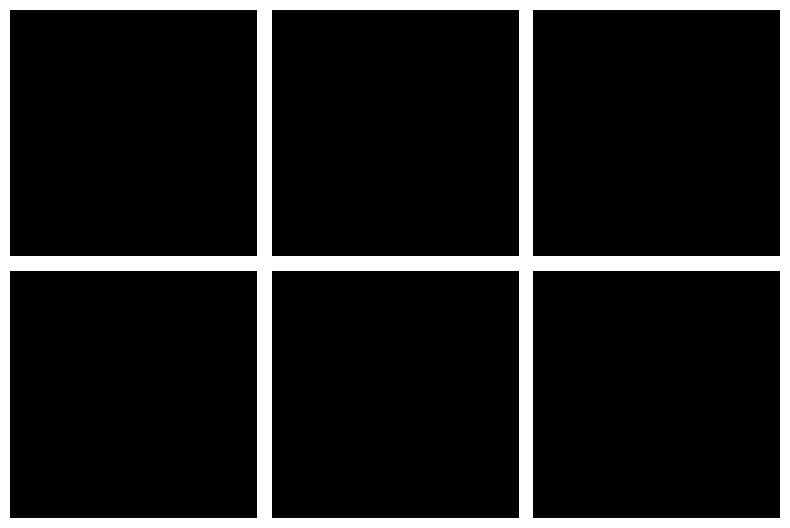

1/1 [==============================] - 0s 21ms/step


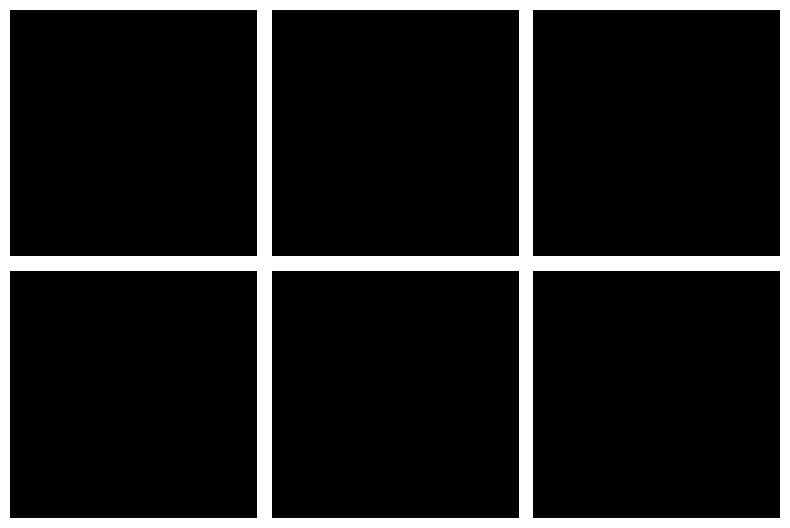

1/1 [==============================] - 0s 21ms/step


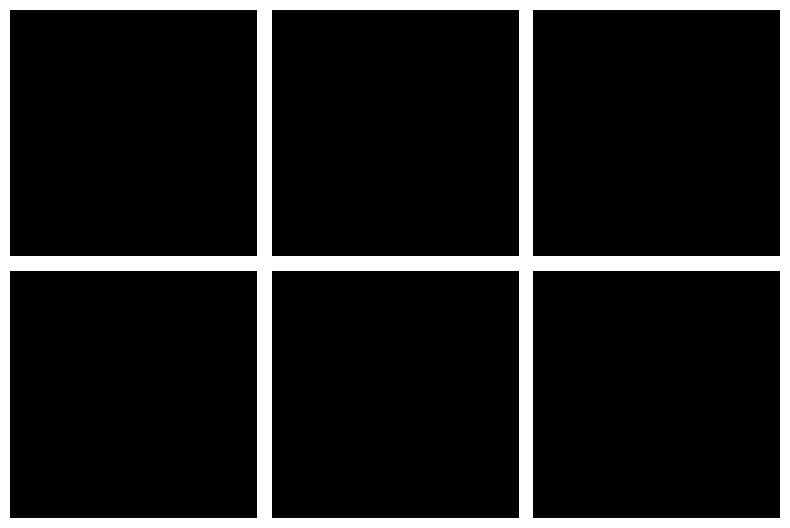

1/1 [==============================] - 0s 22ms/step


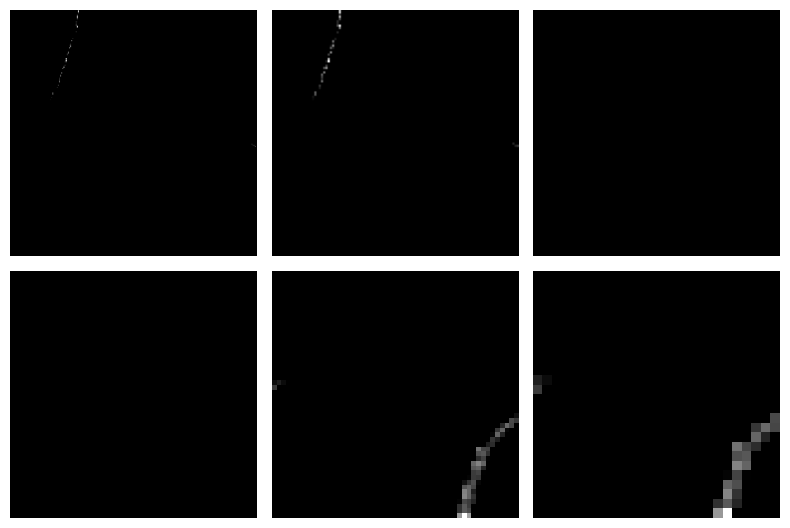

1/1 [==============================] - 0s 21ms/step


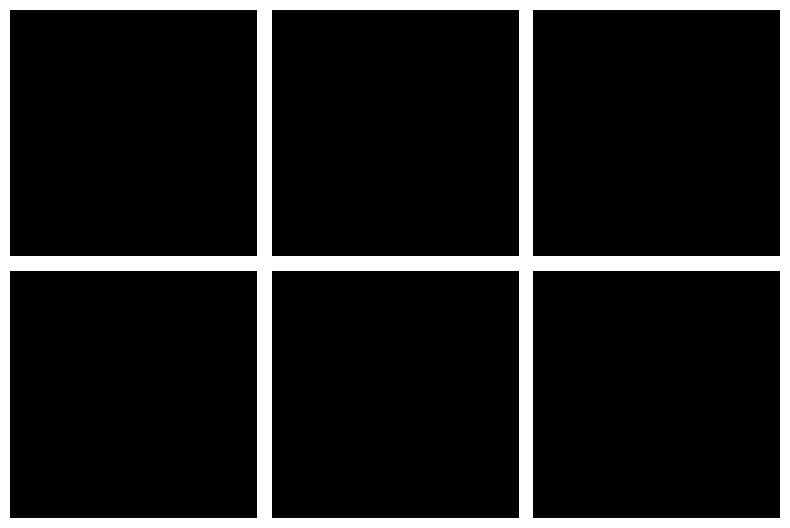

1/1 [==============================] - 0s 20ms/step


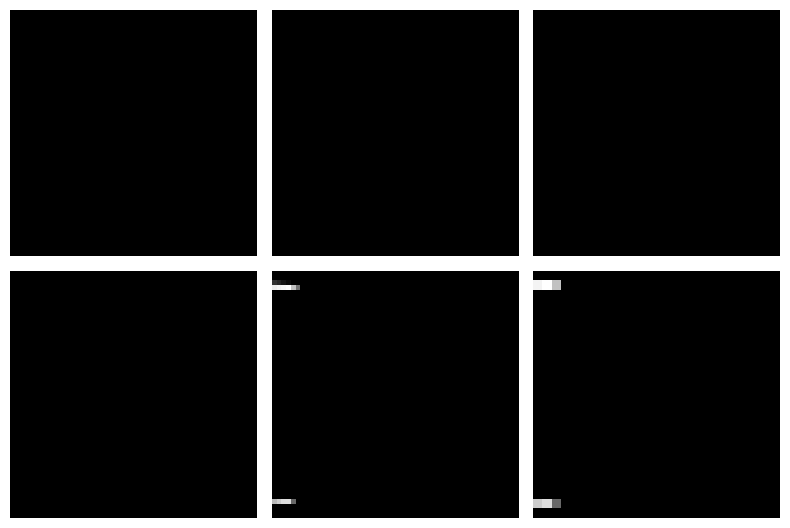

1/1 [==============================] - 0s 20ms/step


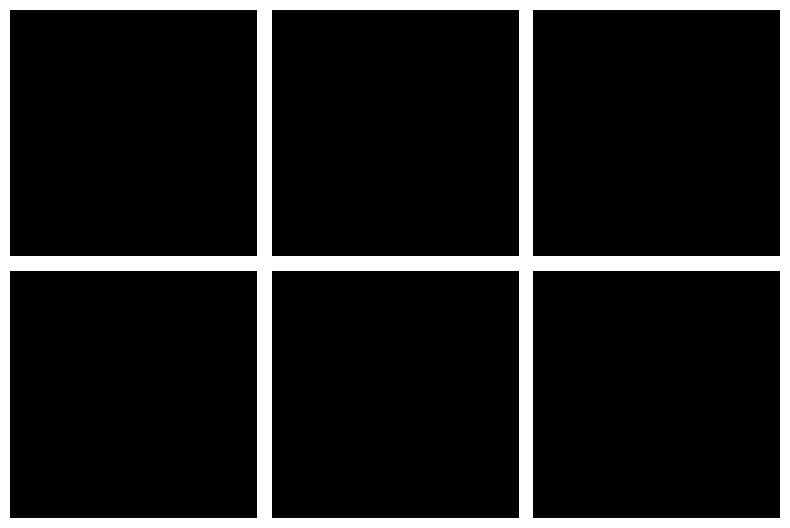

1/1 [==============================] - 0s 25ms/step


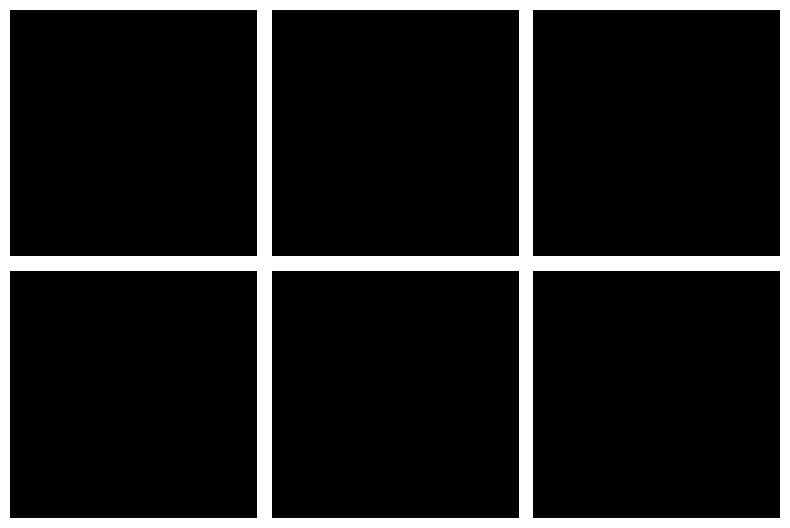

In [22]:
# Use the training_datagen defined earlier to apply data augmentation
# and create a generator with a batch size of 10
future_maps_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=10
)

# Retrieve 10 images from the generator
images, labels = next(future_maps_generator)

# Get the predicted class probabilities for each image
pred_probs = model.predict(images)

# Get the predicted and actual class names for each image
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
pred_classes = [class_names[np.argmax(pred_probs[i])] for i in range(len(images))]
actual_classes = [class_names[np.argmax(labels[i])] for i in range(len(images))]

layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Visualize the feature maps for each image along with the predicted and actual class names
for idx, image in enumerate(images):
    # Expand dimensions for single image prediction
    image = np.expand_dims(image, axis=0)

    # Get the feature maps for the current image
    activations = activation_model.predict(image)

    # Plot the feature maps and class names
    plt.figure(figsize=(8, 8))
    for i in range(len(activations)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(activations[i][0, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [29]:
model.save('jagungv4.h5')